In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.feature import hog  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [86]:
def load_images_from_folder(base_folder, image_size=(224, 224)):
    features = []
    y_shape = []
    y_quality = []
    
    shape_to_label = {'Square': 0, 'Circle': 1, 'Triangle': 2}
    quality_to_label = {'irregular': 0, 'medium': 1, 'perfect': 2}
    
    valid_extensions = {'.png', '.jpg', '.jpeg'}
    
    for shape in ['Square', 'Circle', 'Triangle']:
        shape_folder = os.path.join(base_folder, shape)
        
        if not os.path.exists(shape_folder):
            continue
            
        shape_label = shape_to_label[shape]
        
        for subdir, _, files in os.walk(shape_folder):
            quality_name = os.path.basename(subdir).lower()
            
            if quality_name not in quality_to_label:
                continue
                
            quality_label = quality_to_label[quality_name]
            
            for file in files:
                # Check extension case-insensitively
                _, ext = os.path.splitext(file)
                if ext.lower() in valid_extensions:
                    img_path = os.path.join(subdir, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        img_resized = cv2.resize(img, image_size, interpolation=cv2.INTER_LANCZOS4)
                        
                        # Robust HOG features
                        fd = hog(img_resized,
                                 orientations=9,
                                 pixels_per_cell=(16, 16),
                                 cells_per_block=(2, 2),
                                 block_norm='L1',
                                 transform_sqrt=True)
                        
                        features.append(fd)
                        y_shape.append(shape_label)
                        y_quality.append(quality_label)
    
    return np.array(features), np.array(y_shape), np.array(y_quality)

In [87]:
train_base = '/kaggle/input/dataset-fai/Dataset/train'
train_base = '/kaggle/input/dataset-fai/Dataset/train'
val_base   = '/kaggle/input/dataset-fai/Dataset/val'
test_base  = '/kaggle/input/dataset-fai/Dataset/test'

X_train, y_train_shape, y_train_quality = load_images_from_folder(train_base)
X_val,   y_val_shape,   y_val_quality   = load_images_from_folder(val_base)
X_test,  y_test_shape,  y_test_quality  = load_images_from_folder(test_base)

print(f"Train images loaded: {len(X_train)}")
print(f"Validation images loaded: {len(X_val)}")
print(f"Test images loaded: {len(X_test)}")
print(f"Total: {len(X_train) + len(X_val) + len(X_test)}")

Train images loaded: 319
Validation images loaded: 79
Test images loaded: 90
Total: 488


In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Loaded - Train: {X_train.shape[0]} samples ({X_train.shape[1]} HOG features each)")
print(f"Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Loaded - Train: 638 samples (6084 HOG features each)
Validation: 148, Test: 180


In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001],
    "kernel": ["rbf"]
}

grid_shape = GridSearchCV(
    SVC(class_weight="balanced"),
    params,
    scoring="f1_macro",
    cv=5
)

grid_shape.fit(X_train, y_train_shape)

best_shape_model = grid_shape.best_estimator_

In [71]:
grid_quality = GridSearchCV(
    SVC(class_weight="balanced"),
    params,
    scoring="f1_macro",
    cv=5
)

grid_quality.fit(X_train, y_train_quality)

best_quality_model = grid_quality.best_estimator_


Shape Validation Report:
               precision    recall  f1-score   support

      Square       0.97      0.55      0.70        58
      Circle       0.90      0.81      0.85        47
    Triangle       0.58      0.98      0.72        43

    accuracy                           0.76       148
   macro avg       0.82      0.78      0.76       148
weighted avg       0.83      0.76      0.76       148

Shape Test Metrics: Accuracy=0.7833, Precision=0.8201, Recall=0.7902, F1=0.7852
              precision    recall  f1-score   support

      Square       0.81      0.76      0.78        74
      Circle       1.00      0.67      0.80        55
    Triangle       0.65      0.94      0.77        51

    accuracy                           0.78       180
   macro avg       0.82      0.79      0.79       180
weighted avg       0.82      0.78      0.79       180



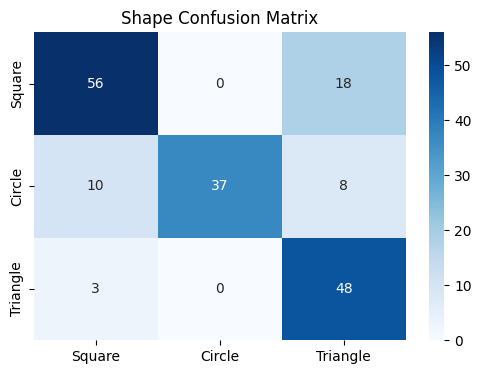


Quality Validation Report:
               precision    recall  f1-score   support

     Perfect       0.48      0.81      0.60        69
      Medium       0.41      0.27      0.33        44
   Irregular       1.00      0.06      0.11        35

    accuracy                           0.47       148
   macro avg       0.63      0.38      0.35       148
weighted avg       0.58      0.47      0.40       148

Quality Test Metrics: Accuracy=0.5278, Precision=0.5487, Recall=0.3937, F1=0.3547
              precision    recall  f1-score   support

     Perfect       0.54      0.91      0.68        90
      Medium       0.44      0.22      0.29        50
   Irregular       0.67      0.05      0.09        40

    accuracy                           0.53       180
   macro avg       0.55      0.39      0.35       180
weighted avg       0.54      0.53      0.44       180



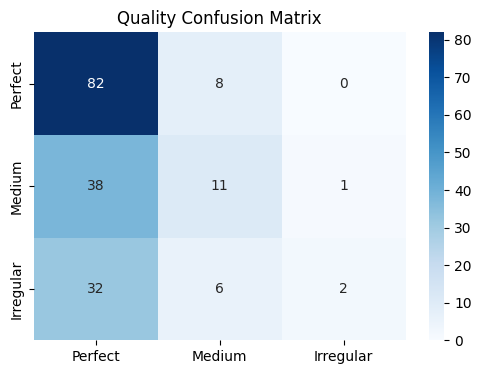

In [72]:
def train_and_evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test, class_names, target_name):
    svm = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm.fit(X_train, y_train)
    
    # Validate
    y_val_pred = svm.predict(X_val)
    print(f"\n{target_name} Validation Report:\n", classification_report(y_val, y_val_pred, target_names=class_names))
    
    # Test
    y_test_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average='macro')
    rec = recall_score(y_test, y_test_pred, average='macro')
    f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"{target_name} Test Metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    print(classification_report(y_test, y_test_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{target_name} Confusion Matrix")
    plt.show()
    
    return svm

# Class names
shape_classes = ['Square', 'Circle', 'Triangle']
quality_classes = ['Perfect', 'Medium', 'Irregular']

# Train for Shape
svm_shape = train_and_evaluate_svm(X_train, y_train_shape, X_val, y_val_shape, X_test, y_test_shape, shape_classes, "Shape")

# Train for Quality
svm_quality = train_and_evaluate_svm(X_train, y_train_quality, X_val, y_val_quality, X_test, y_test_quality, quality_classes, "Quality")

In [73]:
import cv2
from skimage.feature import hog

def predict_new_image(image_path, svm_shape, svm_quality, scaler,
                      shape_classes, quality_classes, image_size=(224, 224)):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Could not read image:", image_path)
        return None, None

    img_resized = cv2.resize(img, image_size, interpolation=cv2.INTER_LANCZOS4)

    fd = hog(
        img_resized,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L1',
        transform_sqrt=True,
        visualize=False
    )

    features = scaler.transform([fd])

    shape_pred = shape_classes[svm_shape.predict(features)[0]]
    quality_pred = quality_classes[svm_quality.predict(features)[0]]

    return shape_pred, quality_pred

In [81]:
image_path = "/kaggle/input/dataset-fai/Dataset/val/Square/irregular/1_15351.jpg"

shape, quality = predict_new_image(
    image_path,
    svm_shape=best_shape_model,
    svm_quality=best_quality_model,
    scaler=scaler,
    shape_classes=shape_classes,
    quality_classes=quality_classes
)

print("Predicted Shape:", shape)
print("Predicted Quality:", quality)


Predicted Shape: Square
Predicted Quality: Perfect
